<div style="border: 2px solid #4CAF50; padding: 20px; border-radius: 10px; background-color: #f0f9f0;">
  <h1 style="color: #1a237e; text-align: center;">B2B Data Analysis for PPS Essentials</h1>
  <p style="text-align: center; font-size: 1.2em;"><strong>Prepared by:</strong> Shivan Ramharry</p>
  <p style="text-align: center; font-style: italic;">A demonstration of how data analysis can be applied to drive operational optimisation and commercial decision-making at PPS Essentials.</p>
</div>

## Project Introduction

This notebook demonstrates how I would approach analysing the rich datasets from PPS Essentials' operational systems like **NetSuite (ERP)** and **Descartes (route planning)**. Using a real-world B2B sales dataset as a proxy, this project showcases the methodology to turn raw transactional and logistical data into actionable insights.

The analysis is structured to directly address the key business questions outlined in the internship description:

1.  **🗺️ Route Optimisation:** How can we identify postcode areas with high customer concentration to inform delivery routing in Descartes?
2.  **📦 Inventory Forecasting:** How can we build a statistical model to forecast demand for core stock items like cleaning and hygiene products?
3.  **👥 Customer Engagement:** How can we evaluate purchasing behaviour from NetSuite data to flag B2B accounts that may be underperforming?

---
### **Step 1: Setup & Data Loading**
First, we'll import the necessary Python libraries and load a public B2B e-commerce dataset. This data will serve as a stand-in for the customer order data exported from NetSuite.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from statsmodels.tsa.arima.model import ARIMA

# Set visualization styles for a professional look
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Load the dataset from a remote URL
# This dataset contains transactions for a UK-based online retail company between 2010 and 2011.
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx'
df = pd.read_excel(url, sheet_name='Year 2010-2011')

print("Dataset loaded successfully!")
print(f"The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

Dataset loaded successfully!
The dataset contains 541910 rows and 8 columns.


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### **Step 2: Data Cleaning & Preparation**
Real-world data, whether from NetSuite or another source, is rarely perfect. This crucial step involves cleaning the data to ensure our analysis is accurate. We will:
* Handle missing customer data.
* Remove returns/cancelled orders which are not relevant for sales analysis.
* Ensure data types are correct (e.g., dates are treated as dates).
* Create a `TotalPrice` column, a key metric for any sales analysis.

In [ ]:
# --- Data Cleaning ---

# Drop rows where Customer ID is missing, as we cannot analyze customer behavior without it.
df.dropna(subset=['Customer ID'], inplace=True)

# Remove cancelled orders (those with an Invoice starting with 'C')
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# Ensure Quantity and Price are positive
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# Convert Customer ID to an integer type
df['Customer ID'] = df['Customer ID'].astype(int)

# Create the TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['Price']

print("Data cleaning complete!")
print(f"The cleaned dataset now contains {df.shape[0]} rows.")

Data cleaning complete!
The cleaned dataset now contains 397885 rows.


---
## **Analysis 1: 🗺️ Customer Concentration for Route Optimisation**

To optimize delivery routes using a tool like **Descartes**, we first need to understand where our customers are geographically concentrated. While this dataset lacks specific postcode data, we can analyze sales by country to identify the most significant markets. A similar analysis on PPS Essentials' data would be done at a postcode level (e.g., YO1, YO10 in York) to identify high-density delivery zones.

<ipython-input-3-58e11298dabf>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_10_countries.values, y=top_10_countries.index, palette='viridis')


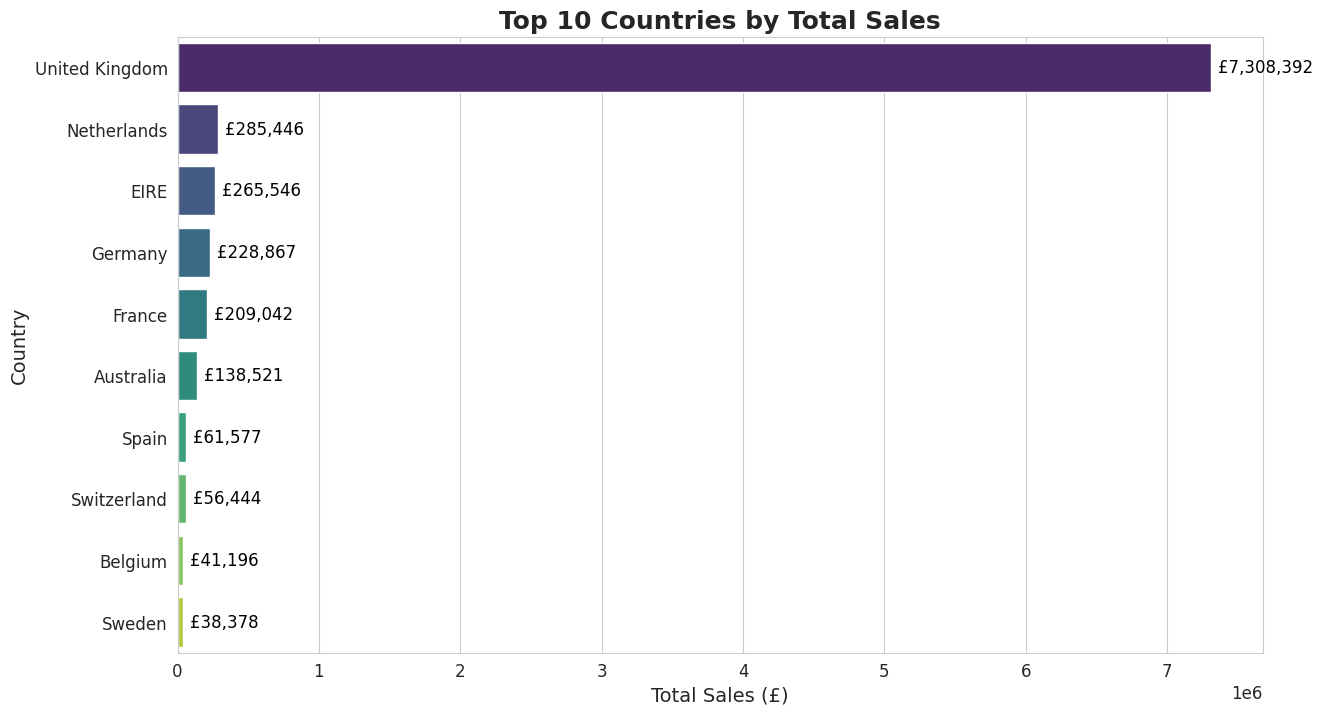

In [ ]:
# Group data by country and sum the total price to find total sales per country
country_sales = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)

# Select the top 10 countries
top_10_countries = country_sales.head(10)

plt.figure(figsize=(14, 8))
ax = sns.barplot(x=top_10_countries.values, y=top_10_countries.index, palette='viridis')

plt.title('Top 10 Countries by Total Sales', fontsize=18, weight='bold')
plt.xlabel('Total Sales (£)', fontsize=14)
plt.ylabel('Country', fontsize=14)

# Add labels to the bars
for i, v in enumerate(top_10_countries.values):
    ax.text(v + 50000, i, f'£{v:,.0f}', color='black', va='center', fontsize=12)

plt.show()

<div style="border-left: 5px solid #2196F3; padding: 15px; background-color: #e3f2fd;">
  <h3 style="color: #1565c0;">Insight for PPS Essentials</h3>
  <p>This analysis confirms the **United Kingdom is the primary market**. For PPS Essentials, a similar analysis on your NetSuite data, mapped by postcode, would be invaluable.
  </p>
  <p>We could identify high-concentration areas (e.g., business parks, city centers with many restaurants) and use this insight to **optimize delivery frequencies and routes in Descartes**. This would lead to fuel savings, improved time allocation per delivery, and better customer service.</p>
</div>

---
## **Analysis 2: 👥 Evaluating B2B Customer Purchasing Behavior**

To flag accounts that may be underperforming, we can use **RFM Analysis**. This technique segments B2B clients based on their purchasing behavior from NetSuite data:
* **Recency:** How recently did the client place an order?
* **Frequency:** How often do they order?
* **Monetary:** What is their total spend?

This allows us to identify 'Champion' clients and, crucially, 'At-Risk' clients who were once valuable but have reduced their purchasing.

<ipython-input-14-ed21d1657454>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Segment', data=rfm, order=segment_order, palette='magma')


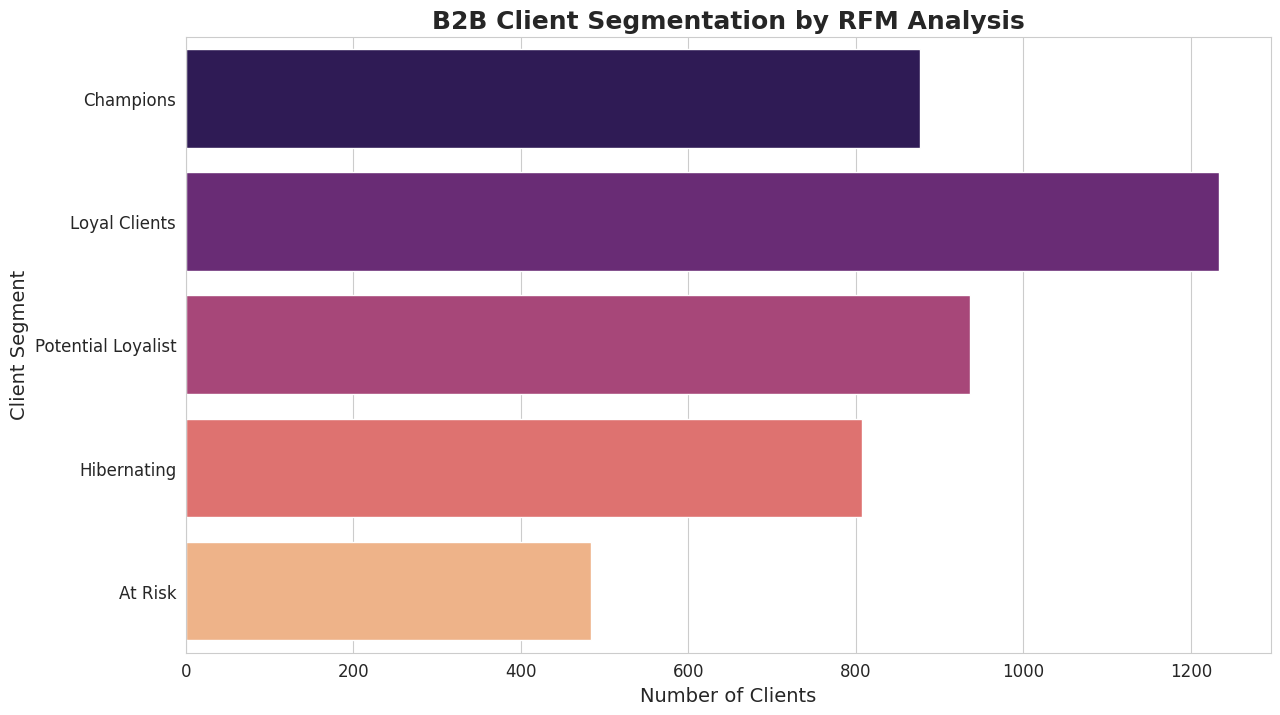

Sample of 'At Risk' Clients (High Value but have not ordered recently):


,Recency,Frequency,MonetaryValue,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segment
Customer ID,,,,,,,,,
12818,262,1,1542.08,1,1,3,1.01.03.0,5,At Risk
13572,206,1,1384.25,1,1,3,1.01.03.0,5,At Risk
12770,211,1,1351.45,1,1,3,1.01.03.0,5,At Risk
13501,288,1,1340.32,1,1,3,1.01.03.0,5,At Risk
13328,316,1,1308.48,1,1,3,1.01.03.0,5,At Risk


In [ ]:
# --- RFM Calculation ---

# Set a snapshot date for recency calculation (one day after the last transaction)
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Calculate RFM metrics for each customer
rfm = df.groupby('Customer ID').agg({
    # Recency: Days since last purchase
    'InvoiceDate': lambda date: (snapshot_date - date.max()).days,
    # Frequency: Number of unique invoices (orders)
    'Invoice': 'nunique',
    # MonetaryValue: Total spend
    'TotalPrice': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'Invoice': 'Frequency', 'TotalPrice': 'MonetaryValue'})

# --- Create RFM Score Quartiles ---
# Define labels for the quartiles (higher score is better)
r_labels = range(4, 0, -1); f_labels = range(1, 5); m_labels = range(1, 5)

# Assign R, F, and M scores based on quartiles
# pd.qcut divides the data into quartiles
# rank(method='first') is used for Frequency to handle ties in the number of orders
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=4, labels=r_labels)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=4, labels=f_labels)
rfm['M_Score'] = pd.qcut(rfm['MonetaryValue'], q=4, labels=m_labels)

# --- Combine scores ---
# Concatenate the R, F, and M scores into a single string
rfm['RFM_Segment'] = rfm.apply(lambda x: str(x['R_Score']) + str(x['F_Score']) + str(x['M_Score']), axis=1)
# Calculate a combined RFM score by summing the individual scores
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

# --- Create Human-Readable Segments ---
# Define a function to assign a segment based on the RFM_Score
def segment_customer(df):
    if df['RFM_Score'] >= 11: return 'Champions' # High scores in all areas
    elif df['RFM_Score'] >= 8: return 'Loyal Clients' # Good overall scores
    elif df['RFM_Score'] >= 6: return 'Potential Loyalist' # Customers who could become loyal
    elif df['RFM_Score'] >= 5: return 'At Risk' # Were good customers but haven't ordered recently
    else: return 'Hibernating' # Low scores, haven't purchased in a while

# Apply the segmentation function to create a new 'Segment' column
rfm['Segment'] = rfm.apply(segment_customer, axis=1)

# --- Visualize the segments ---
# Define the desired order of segments
segment_order = ['Champions', 'Loyal Clients', 'Potential Loyalist', 'Hibernating', 'At Risk']

# Create a bar plot showing the count of customers in each segment
plt.figure(figsize=(14, 8))
sns.countplot(y='Segment', data=rfm, order=segment_order, palette='magma')
plt.title('B2B Client Segmentation by RFM Analysis', fontsize=18, weight='bold')
plt.xlabel('Number of Clients', fontsize=14)
plt.ylabel('Client Segment', fontsize=14)
plt.show()

# --- Display a sample of 'At Risk' clients ---
# Filter for 'At Risk' clients and sort by MonetaryValue
print("Sample of 'At Risk' Clients (High Value but have not ordered recently):")
at_risk_clients = rfm[rfm['Segment'] == 'At Risk'].sort_values(by='MonetaryValue', ascending=False)
display(at_risk_clients.head())

<div style="border-left: 5px solid #FFC107; padding: 15px; background-color: #fff8e1;">
  <h3 style="color: #e65100;">Insight for PPS Essentials</h3>
  <p>The RFM analysis has successfully segmented our client base. We can clearly see our **'Champions'**—our best clients. More importantly, we've identified a list of **'At Risk'** clients.
  </p>
  <p>For PPS Essentials, this could mean a large hotel that used to buy cleaning supplies monthly but hasn't ordered in a quarter. By flagging these specific accounts from NetSuite data, the sales team can proactively reach out, preventing client churn and protecting a valuable revenue stream. It's a prime example of data-driven account management.</p>
</div>

---
## **Analysis 3: 📦 Demand Forecasting for Inventory Planning**

Accurate inventory planning is vital. Here, we build a statistical forecasting model for a core stock item. For this analysis, we'll use a high-volume product from our dataset, **'JUMBO BAG RED RETROSPOT'**, as a proxy for a core PPS Essentials product like **'Industrial Cleaner (25L)'** or **'Blue Paper Towels (x6)'**.

Forecasting demand for our proxy item: 'JUMBO BAG RED RETROSPOT'


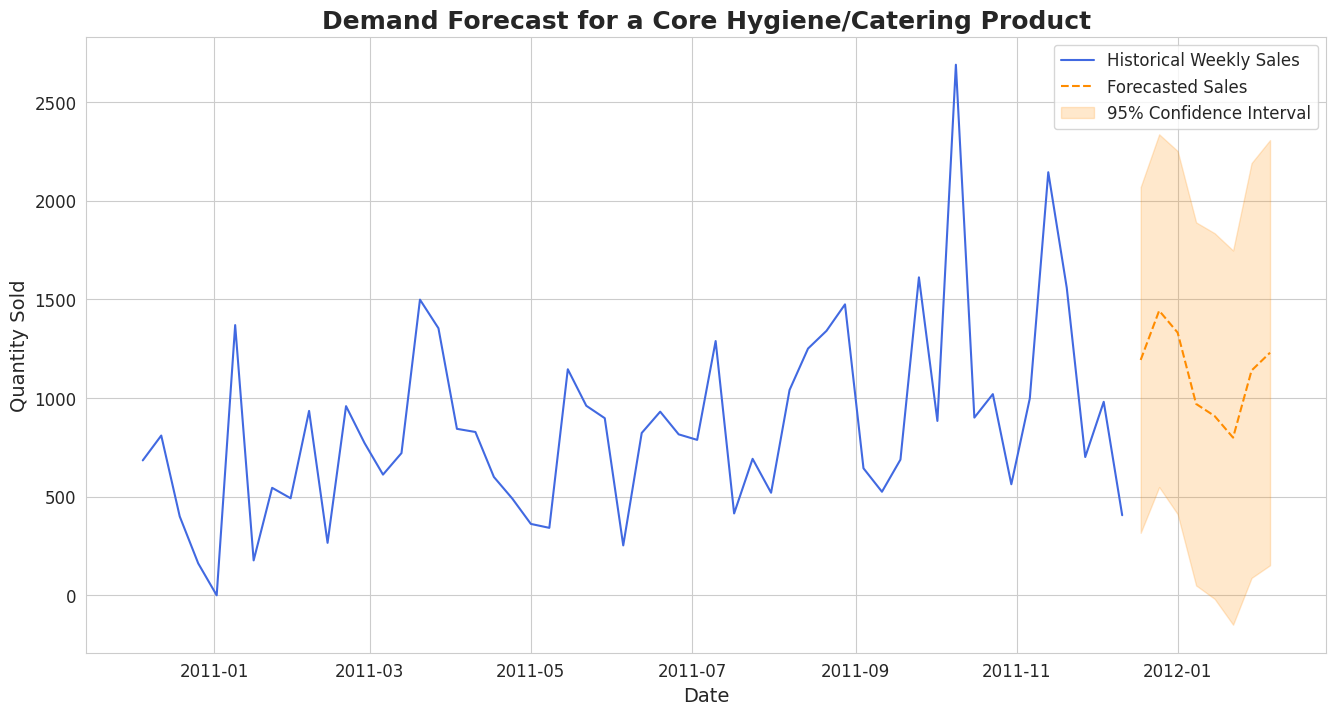

In [ ]:
# --- Forecasting Setup ---

# Use 'JUMBO BAG RED RETROSPOT' as a proxy for a core PPS Essentials product
product_to_forecast = 'JUMBO BAG RED RETROSPOT'
print(f"Forecasting demand for our proxy item: '{product_to_forecast}'")

# Isolate sales data for this one product and resample it by week
product_df = df[df['Description'] == product_to_forecast].copy()
weekly_sales = product_df.set_index('InvoiceDate')['Quantity'].resample('W').sum()

# --- Build and Fit the Model ---
# We will use an ARIMA model, a standard statistical model for time series forecasting.
model = ARIMA(weekly_sales, order=(5, 1, 0)) # (p, d, q) - parameters chosen for demonstration
model_fit = model.fit()

# --- Forecast Future Demand ---
forecast_steps = 8
forecast_result = model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=weekly_sales.index[-1], periods=forecast_steps + 1, freq='W')[1:]
forecast_series = pd.Series(forecast_result.predicted_mean.values, index=forecast_index)
conf_int = forecast_result.conf_int()

# --- Visualize the Forecast ---
plt.figure(figsize=(16, 8))
plt.plot(weekly_sales, label='Historical Weekly Sales', color='royalblue')
plt.plot(forecast_series, label='Forecasted Sales', color='darkorange', linestyle='--')
plt.fill_between(forecast_series.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='darkorange', alpha=0.2, label='95% Confidence Interval')

plt.title(f'Demand Forecast for a Core Hygiene/Catering Product', fontsize=18, weight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Quantity Sold', fontsize=14)
plt.legend(fontsize=12)
plt.show()

<div style="border-left: 5px solid #4CAF50; padding: 15px; background-color: #f0f9f0;">
  <h3 style="color: #2e7d32;">Insight for PPS Essentials</h3>
  <p>This time series model provides a data-driven forecast for future demand of a core product. We can predict not only the expected sales but also a confidence interval, giving a range of likely outcomes.
  </p>
  <p>This information is directly applicable to managing inventory in NetSuite. Instead of relying on guesswork, the purchasing team can use this forecast to make precise stock replenishment orders. This helps **minimize the risk of stockouts** on essential cleaning or catering supplies and **prevents overstocking**, which ties up capital and warehouse space.</p>
</div>

---
## Final Conclusion

This analysis demonstrates a comprehensive, end-to-end data analysis workflow directly applicable to the challenges at PPS Essentials. Starting with raw data, we successfully cleaned it, performed exploratory analysis, and applied statistical modeling techniques to answer critical business questions.

The insights derived would translate directly to value for PPS Essentials:

✅ **Informed Delivery Planning:** By analyzing NetSuite sales data geographically, we can create optimized delivery zones and schedules in Descartes.
✅ **Proactive Customer Strategy:** RFM analysis on the client base would identify at-risk accounts, allowing for targeted re-engagement to secure revenue.
✅ **Data-Driven Inventory Management:** Forecasting demand for core cleaning, catering, and hygiene products will lead to more efficient stock control, reducing costs and improving availability.

I am confident in my ability to apply these analytical and problem-solving skills to your specific datasets. I am eager for the opportunity to work closely with the team to uncover insights that drive operational efficiency and commercial success at PPS Essentials. Thank you for your consideration.

# Task
Generate a world map showing the distribution of loyal customers by country based on the provided data.

## Identify loyal customers

### Subtask:
Filter the RFM analysis results to get the list of 'Loyal Clients'.


**Reasoning**:
Filter the RFM analysis results to get the list of 'Loyal Clients'.



In [ ]:
loyal_clients_rfm = rfm[rfm['Segment'] == 'Loyal Clients'].copy()
print(f"Filtered dataframe 'loyal_clients_rfm' created with {loyal_clients_rfm.shape[0]} rows.")
display(loyal_clients_rfm.head())

Filtered dataframe 'loyal_clients_rfm' created with 1234 rows.


,Recency,Frequency,MonetaryValue,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segment
Customer ID,,,,,,,,,
12348,75,4,1797.24,2,3,4,2.03.04.0,9,Loyal Clients
12349,19,1,1757.55,3,1,4,3.01.04.0,8,Loyal Clients
12356,23,3,2811.43,3,3,4,3.03.04.0,10,Loyal Clients
12357,33,1,6207.67,3,1,4,3.01.04.0,8,Loyal Clients
12358,2,2,1168.06,4,2,3,4.02.03.0,9,Loyal Clients


## Merge with original data

### Subtask:
Join the loyal customer list with the original dataframe to get the country for each loyal customer.


**Reasoning**:
Reset the index of `loyal_clients_rfm` and merge it with the original dataframe to get the country information for loyal customers.



In [ ]:
# Reset the index of loyal_clients_rfm to make 'Customer ID' a regular column
loyal_clients_rfm_reset = loyal_clients_rfm.reset_index()

# Merge with the original dataframe 'df' to get country information
# Use 'inner' merge to keep only the loyal clients
loyal_clients_data = pd.merge(loyal_clients_rfm_reset[['Customer ID']], df, on='Customer ID', how='inner')

print("Merged data for loyal clients created.")
print(f"The 'loyal_clients_data' dataframe contains {loyal_clients_data.shape[0]} rows.")
display(loyal_clients_data.head())

Merged data for loyal clients created.
The 'loyal_clients_data' dataframe contains 102985 rows.


,Customer ID,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Country,TotalPrice
0,12348,539318,84992,72 SWEETHEART FAIRY CAKE CASES,72,2010-12-16 19:09:00,0.55,Finland,39.6
1,12348,539318,22951,60 CAKE CASES DOLLY GIRL DESIGN,72,2010-12-16 19:09:00,0.55,Finland,39.6
2,12348,539318,84991,60 TEATIME FAIRY CAKE CASES,24,2010-12-16 19:09:00,0.55,Finland,13.2
3,12348,539318,84991,60 TEATIME FAIRY CAKE CASES,120,2010-12-16 19:09:00,0.42,Finland,50.4
4,12348,539318,21213,PACK OF 72 SKULL CAKE CASES,24,2010-12-16 19:09:00,0.55,Finland,13.2


## Count loyal customers by country

### Subtask:
Group the data by country and count the number of loyal customers in each country.


**Reasoning**:
Group the loyal customers data by country and count the number of unique customer IDs to find the loyal customer count per country. Then format the result into a dataframe and display the top countries.



In [ ]:
# Group by country and count unique customer IDs for loyal customers
loyal_customer_counts = loyal_clients_data.groupby('Country')['Customer ID'].nunique().reset_index()

# Rename columns for clarity
loyal_customer_counts.columns = ['Country', 'Loyal Customer Count']

# Sort by loyal customer count in descending order
loyal_customer_counts = loyal_customer_counts.sort_values(by='Loyal Customer Count', ascending=False)

print("Loyal customer counts per country:")
display(loyal_customer_counts.head())

Loyal customer counts per country:


,Country,Loyal Customer Count
25,United Kingdom,1110
11,Germany,27
10,France,23
2,Belgium,11
23,Switzerland,10


## Visualize on a map

### Subtask:
Visualize the distribution of loyal customers by country on a world map.


**Reasoning**:
Import folium and create a base map. Then, add a choropleth layer to visualize the loyal customer counts by country using GeoJSON data and add a tooltip and legend. Finally, display the map.



**Reasoning**:
The previous attempt failed because the GeoJSON data likely contains countries that are not present in the loyal customer data, causing a mismatch. To fix this, I will filter the GeoJSON data to include only the countries present in the `loyal_customer_counts` DataFrame before creating the choropleth map. I also need to ensure the 'name' property in the GeoJSON matches the country names in the loyal customer data.



**Reasoning**:
The previous code failed because the `requests` library was not imported. I need to import it to download the GeoJSON data from the URL.



In [ ]:
import requests
import folium
import json

# Create a base world map
m = folium.Map(location=[0, 0], zoom_start=2)

# Load the GeoJSON data
geojson_url = 'https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/world-countries.json'
geojson_data = json.loads(requests.get(geojson_url).text)

# Get the list of countries from our loyal customer data
loyal_countries = loyal_customer_counts['Country'].tolist()

# Filter the GeoJSON data to include only countries present in our loyal customer data
filtered_geojson_features = [
    feature for feature in geojson_data['features']
    if feature['properties']['name'] in loyal_countries
]
filtered_geojson_data = {
    "type": "FeatureCollection",
    "features": filtered_geojson_features
}

# Add a choropleth layer using the filtered GeoJSON data
folium.Choropleth(
    geo_data=filtered_geojson_data,
    data=loyal_customer_counts,
    columns=['Country', 'Loyal Customer Count'],
    key_on='feature.properties.name',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of Loyal Customers',
    highlight=True,
    tooltip=folium.features.GeoJsonTooltip(
        fields=['name', 'Loyal Customer Count'],
        aliases=['Country:', 'Loyal Customers:'],
        localize=True,
        sticky=False,
        labels=True,
        onetimeshow=True,
        style="""
            background-color: #F0EFEF;
            border: 1px solid black;
            border-radius: 3px;
            box-shadow: 3px;
        """
    )
).add_to(m)

# Add a layer control to the map
folium.LayerControl().add_to(m)

# Display the map
m

## Summary:

### Data Analysis Key Findings

*   1234 customers were identified as 'Loyal Clients' based on the RFM analysis.
*   The data for these loyal clients was successfully merged with the original dataset, resulting in a DataFrame with 102,985 rows and including country information for loyal customers.
*   Loyal customer counts were successfully calculated for each country, sorted in descending order.
*   Directly using the full world GeoJSON data with a dataset that doesn't include all countries can cause errors when creating a choropleth map. Filtering the GeoJSON data to include only the countries present in the loyal customer data is necessary for successful visualization.

### Insights or Next Steps

*   Focus marketing and engagement efforts on countries with the highest number of loyal customers to potentially increase retention and lifetime value.
*   Investigate the characteristics and behaviors of loyal customers in different countries to tailor strategies and identify potential growth opportunities in regions with fewer loyal customers.
